In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy as cp
from sklearn.metrics import accuracy_score
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics
from sklearn.model_selection import train_test_split

In [6]:
def evaluate(true, preds):
    TP = np.sum((true == 1) & (preds == 1))
    FP = np.sum((true == 0) & (preds == 1))
    TN = np.sum((true == 0) & (preds == 0))
    FN = np.sum((true == 1) & (preds == 0))
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1 = 2 * ((recall * precision)/(recall + precision))
    print(f" Accuracy: {accuracy} \n Recall: {recall} \n Specificity: {specificity} \n Precision: {precision} \n F1: {f1}")
    return [accuracy, recall]

In [3]:
class MLP:

    def __init__(self, X, y, hidden_layer_sizes, activation="sigmoid",
                  learning_rate=0.01, epochs=100, random_state=None,
                  weights=[], bias=[], activation_output="linear", random_w_min = -1, random_w_max = 1,
                  cv_X = None, cv_y = None, print_evey_n_epoch = 100, momentum = 0,
                    epsilon = 1e-8, beta = 0.9, batch_size = None, optimizer = None,
                    beta1_adam =0.9, beta2_adam = 0.999, save_best = False,
                    dropout=[]):
        self.X = pd.DataFrame(X)
        self.y = pd.DataFrame(y)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = cp.deepcopy(activation)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.weights = cp.deepcopy(weights)
        self.bias = cp.deepcopy(bias)
        self.output_size = None
        self.activation_output = cp.deepcopy(activation_output)
        self.random_w_min = random_w_min
        self.random_w_max = random_w_max
        self.cv_X = cp.deepcopy(cv_X)
        self.cv_y = cp.deepcopy(pd.DataFrame(cv_y))
        self.random_w_bool = False
        self.declared_weights = cp.deepcopy(weights)
        self.declared_bias = cp.deepcopy(bias)
        self.print_evey_n_epoch = cp.deepcopy(print_evey_n_epoch)
        self.batch_size = cp.deepcopy(batch_size)
        self.momentum = cp.deepcopy(momentum)
        self.epsilon = cp.deepcopy(epsilon)
        self.beta = cp.deepcopy(beta)
        self.optimizer = cp.deepcopy(optimizer)
        self.beta1_adam = cp.deepcopy(beta1_adam)
        self.beta2_adam = cp.deepcopy(beta2_adam)
        self.rmsprop_w = None
        self.rmsprop_b = None
        self.adam_m_w = None
        self.adam_m_b = None
        self.adam_v_w = None
        self.adam_v_b = None
        self.t = 0
        self.prev_delta_w = None
        self.prev_delta_b = None
        self.min_cost_function_train = None
        self.min_cost_function_val = None
        self.save_best = cp.deepcopy(save_best)
        self.best_weights = None
        self.best_bias = None
        self.dropout = cp.deepcopy(dropout)
        

    def activation_function(self, x):
        if self.activation == "sigmoid":
            return 1/(1+np.exp(-x))
        if self.activation == "relu":
            return np.maximum(0,x)
        if self.activation == "tanh":
            return np.tanh(x)
        if self.activation == "linear":
            return x
        
    def activation_function_derivative(self, x):
        if self.activation == "sigmoid":
            return (1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x))))
        if self.activation == "relu":
            return np.where(x<=0,0,1)
        if self.activation == "tanh":
            return 1 - np.tanh(x)**2
        if self.activation == "linear":
            return 1
        
    def activation_output_function(self, x):
        if self.activation_output == "sigmoid":
            return 1/(1+np.exp(-x))
        if self.activation_output == "linear":
            return x
        if self.activation_output == "softmax":
            exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def activation_output_function_derivative(self, x):
        if self.activation_output == "sigmoid":
            return (1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x))))
        if self.activation_output == "linear":
            return 1
        if self.activation_output == "softmax":
            exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
            softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            return softmax_probs * (1 - softmax_probs)
        
    def loss_function(self, y, ypred):
        if self.activation_output == "sigmoid":
            return -np.sum(y*np.log(ypred))
        if self.activation_output == "linear":
            lf = np.sum(np.square(y - ypred)) / int(y.shape[0])
            lf = lf.round(4)
            return lf.item()
        if self.activation_output == "softmax":
            return np.sum(np.array([-np.sum(y*np.log(ypred))])).round(4)
        
    def loss_function_derivative(self, y, ypred):
        if self.activation_output == "sigmoid":
            return y-ypred
        if self.activation_output == "linear":
            return 2*(y-ypred)
        if self.activation_output == "softmax":
            return y-ypred
        
    def loss_function_print(self, y, ypred):
        if self.activation_output == "linear":
            return str(np.array([np.sum(np.square(y - ypred)) / y.shape[0]]))[2:-2]
        if self.activation_output == "sigmoid":
            return str(np.array([-np.sum(y*np.log(ypred))]))[2:-2]
        if self.activation_output == "softmax":
            return np.sum(np.array([-np.sum(y*np.log(ypred))])).round(4)
        
    def OneHot(self, y):
        n = y.iloc[:,0].max() + 1
        return np.eye(n)[y]

    def feedforward(self, X, predict=False):
        z = []
        a = []
        for i in range(len(self.weights)):
            if i == 0:
                z.append(np.dot(X, self.weights[i]) + self.bias[i])
                a.append(self.activation_function(z[i]))
            elif i == len(self.weights)-1:
                z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
                a.append(self.activation_output_function(z[i]))
            else:
                z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
                a.append(self.activation_function(z[i]))
        if len(self.dropout) != 0 and predict == False:
            dropout_count = []
            for i in range(len(a)-1):
                temp_count = len(a[i].flatten())
                dropout_count.append(temp_count)

            dropout_factor = [np.ones_like(x).flatten() for x in a[:-1]]
            for layer in range(len(a)-1):
                limit = int(self.dropout[layer] * dropout_count[layer])
                count = 0
                for neuron in range(len(a[layer].flatten())):
                        if count == limit:
                            break
                        else:
                            dropout_factor[layer][neuron] = 0
                            count += 1
                np.random.shuffle(dropout_factor[layer])
                dropout_factor[layer] = dropout_factor[layer].reshape(a[layer].shape)
                a[layer] = a[layer] * dropout_factor[layer]
        return z, a
    
    def backpropagation(self, z, a, y, x):
        delta_w = [0] * len(self.weights)
        delta_w_final = [0] * len(self.weights)
        delta_b = [0] * len(self.bias)
        for i in range(len(self.weights) - 1, -1, -1):
            if i == (len(self.weights) - 1):
                delta_w[i] = self.loss_function_derivative(y, a[i]) * self.activation_output_function_derivative(z[i])
                delta_w_final[i] = np.dot(a[i - 1].T, delta_w[i])
                delta_b[i] = self.loss_function_derivative(y, a[i]) * self.activation_output_function_derivative(z[i])
            elif i == 0:
                delta_w[i] = np.dot(delta_w[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
                delta_w_final[i] = np.dot(x.T, delta_w[i])
                delta_b[i] = np.dot(delta_b[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
            else:
                delta_w[i] = np.dot(delta_w[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
                delta_w_final[i] = np.dot(a[i - 1].T, delta_w[i])
                delta_b[i] = np.dot(delta_b[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
        return delta_w_final, delta_b        

    def fit(self):
        if self.activation_output == "softmax":
            self.output_size = cp.deepcopy(len(np.unique(self.y)))
            self.y = cp.deepcopy(pd.DataFrame(self.OneHot(self.y).reshape(self.y.shape[0], self.output_size)))
            if self.cv_X is not None:
                self.cv_y = cp.deepcopy(pd.DataFrame(self.OneHot(self.cv_y).reshape(self.cv_y.shape[0], self.output_size)))
        else:
            self.output_size = 1
        if len(self.weights) == 0 or len(self.bias) == 0:
            if self.random_state != None:
                np.random.seed(self.random_state)
            else:
                self.random_state = int(np.random.randint(0, 10000000, size=(1, 1)))
                np.random.seed(self.random_state)
            self.random_w_bool = True
            self.weights = [0] * (len(self.hidden_layer_sizes) + 1)
            self.bias = [0] * (len(self.hidden_layer_sizes) + 1)
            for i in range(len(self.hidden_layer_sizes) + 1):
                if i == 0:
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.X.shape[1],self.hidden_layer_sizes[i])).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
                elif i == len(self.hidden_layer_sizes):
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.output_size)).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.output_size)).astype(np.float64)
                else:
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.hidden_layer_sizes[i])).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
        elif len(self.weights) != len(self.bias):
            raise ValueError("Number of weights and bias must be equal")
        else:
            pass
        self.prev_delta_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.prev_delta_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.rmsprop_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.rmsprop_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.adam_m_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.adam_m_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.adam_v_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.adam_v_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.t = 0
        if self.batch_size != None:
            number_of_batches = int(self.X.shape[0] / self.batch_size)
            if self.X.shape[0] % self.batch_size != 0:
                number_of_batches += 1
        else:
            self.batch_size = cp.deepcopy(self.X.shape[0])
            number_of_batches = 1
        for i in range(self.epochs):
            if i == 0:
                self.X = self.X.sample(frac=1, random_state=self.random_state)
                self.y = self.y.sample(frac=1, random_state=self.random_state)
            else:
                self.X = self.X.sample(frac=1, random_state=(self.random_state + i))
                self.y = self.y.sample(frac=1, random_state=(self.random_state + i))
            for n in range(0, number_of_batches):
                delta_w = [np.zeros_like(w) for w in self.weights]
                delta_b = [np.zeros_like(b) for b in self.bias]
                if (n == number_of_batches-1) and (self.X.shape[0] % self.batch_size != 0):
                    for b in range(0, self.X.shape[0] % self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= (self.X.shape[0] % self.batch_size)
                        delta_b[l] /= (self.X.shape[0] % self.batch_size)
                else:
                    for b in range(0, self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= self.batch_size
                        delta_b[l] /= self.batch_size
                for k in range(len(self.weights)):
                    if self.optimizer is None:
                        self.weights[k] += self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k]
                        self.bias[k] += self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k]
                        self.prev_delta_w[k] = cp.deepcopy(self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k])
                        self.prev_delta_b[k] = cp.deepcopy(self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k])
                    elif self.optimizer == "rmsprop":
                        self.rmsprop_w[k] = self.beta * self.rmsprop_w[k] + (1 - self.beta) * delta_w[k] ** 2
                        self.rmsprop_b[k] = self.beta * self.rmsprop_b[k] + (1 - self.beta) * delta_b[k] ** 2
                        self.weights[k] += self.learning_rate * delta_w[k] / (np.sqrt(self.rmsprop_w[k]) + self.epsilon)
                        self.bias[k] += self.learning_rate * delta_b[k] / (np.sqrt(self.rmsprop_b[k]) + self.epsilon)
                    elif self.optimizer == "adam":
                        self.t += 1
                        self.adam_m_w[k] = self.beta1_adam * self.adam_m_w[k] + (1 - self.beta1_adam) * delta_w[k]
                        self.adam_m_b[k] = self.beta1_adam * self.adam_m_b[k] + (1 - self.beta1_adam) * delta_b[k]
                        self.adam_v_w[k] = self.beta2_adam * self.adam_v_w[k] + (1 - self.beta2_adam) * delta_w[k] ** 2
                        self.adam_v_b[k] = self.beta2_adam * self.adam_v_b[k] + (1 - self.beta2_adam) * delta_b[k] ** 2
                        adam_m_w_hat = self.adam_m_w[k] / (1 - self.beta1_adam ** self.t)
                        adam_m_b_hat = self.adam_m_b[k] / (1 - self.beta1_adam ** self.t)
                        adam_v_w_hat = self.adam_v_w[k] / (1 - self.beta2_adam ** self.t)
                        adam_v_b_hat = self.adam_v_b[k] / (1 - self.beta2_adam ** self.t)
                        self.weights[k] += self.learning_rate * adam_m_w_hat / (np.sqrt(adam_v_w_hat) + self.epsilon)
                        self.bias[k] += self.learning_rate * adam_m_b_hat / (np.sqrt(adam_v_b_hat) + self.epsilon)
            preds_train = self.predict(self.X)
            if self.activation_output == "sigmoid":
                loss_train = float(self.loss_function(self.y, preds_train).values[0])
            else:
                loss_train = self.loss_function(self.y, preds_train)
            if self.cv_X is not None:
                preds_val = self.predict(self.cv_X)
                loss_val = self.loss_function(self.cv_y, preds_val)
            if self.min_cost_function_train is None or self.min_cost_function_train > loss_train:
                self.min_cost_function_train = loss_train
                if self.save_best is True:
                    self.best_weights = cp.deepcopy(self.weights)
                    self.best_bias = cp.deepcopy(self.bias)
            if self.cv_X is not None and (self.min_cost_function_val is None or self.min_cost_function_val > loss_val):
                self.min_cost_function_val = loss_val
            if (i+1) % self.print_evey_n_epoch == 0 or i == 0:
                if self.cv_X is None:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        preds_train.columns = ["class"]
                        preds_train["class"] = preds_train["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        f1_train = f1_score(self.y, preds_train["class"], average="binary").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} F1: {f1_train:^7} ===")
                else:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} === Val MSE: {loss_val:^14} === Min: {self.min_cost_function_val:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        preds_val = pd.DataFrame(preds_val).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        f1_val = f1_score(pd.DataFrame(self.cv_y).idxmax(axis=1), preds_val, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        preds_val = pd.DataFrame(preds_val)
                        preds_train.columns = ["class"]
                        preds_val.columns = ["class"]
                        preds_train["class"] = preds_train["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        preds_val["class"] = preds_val["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        f1_train = f1_score(self.y, preds_train["class"], average="binary").round(4)
                        f1_val = f1_score(self.cv_y, preds_val["class"], average="binary").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                
    
    def continue_fit(self, epochs):
        if self.batch_size != None:
            number_of_batches = int(self.X.shape[0] / self.batch_size)
            if self.X.shape[0] % self.batch_size != 0:
                number_of_batches += 1
        else:
            self.batch_size = cp.deepcopy(self.X.shape[0])
            number_of_batches = 1
        for i in range(epochs):
            if i == 0:
                self.X = self.X.sample(frac=1, random_state=self.random_state)
                self.y = self.y.sample(frac=1, random_state=self.random_state)
            else:
                self.X = self.X.sample(frac=1, random_state=(self.random_state + i))
                self.y = self.y.sample(frac=1, random_state=(self.random_state + i))
            for n in range(0, number_of_batches):
                delta_w = [np.zeros_like(w) for w in self.weights]
                delta_b = [np.zeros_like(b) for b in self.bias]
                if (n == number_of_batches-1) and (self.X.shape[0] % self.batch_size != 0):
                    for b in range(0, self.X.shape[0] % self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= (self.X.shape[0] % self.batch_size)
                        delta_b[l] /= (self.X.shape[0] % self.batch_size)
                else:
                    for b in range(0, self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= self.batch_size
                        delta_b[l] /= self.batch_size
                for k in range(len(self.weights)):
                    if self.optimizer is None:
                        self.weights[k] += self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k]
                        self.bias[k] += self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k]
                        self.prev_delta_w[k] = cp.deepcopy(self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k])
                        self.prev_delta_b[k] = cp.deepcopy(self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k])
                    elif self.optimizer == "rmsprop":
                        self.rmsprop_w[k] = self.beta * self.rmsprop_w[k] + (1 - self.beta) * delta_w[k] ** 2
                        self.rmsprop_b[k] = self.beta * self.rmsprop_b[k] + (1 - self.beta) * delta_b[k] ** 2
                        self.weights[k] += self.learning_rate * delta_w[k] / (np.sqrt(self.rmsprop_w[k]) + self.epsilon)
                        self.bias[k] += self.learning_rate * delta_b[k] / (np.sqrt(self.rmsprop_b[k]) + self.epsilon)
                    elif self.optimizer == "adam":
                        self.t += 1
                        self.adam_m_w[k] = self.beta1_adam * self.adam_m_w[k] + (1 - self.beta1_adam) * delta_w[k]
                        self.adam_m_b[k] = self.beta1_adam * self.adam_m_b[k] + (1 - self.beta1_adam) * delta_b[k]
                        self.adam_v_w[k] = self.beta2_adam * self.adam_v_w[k] + (1 - self.beta2_adam) * delta_w[k] ** 2
                        self.adam_v_b[k] = self.beta2_adam * self.adam_v_b[k] + (1 - self.beta2_adam) * delta_b[k] ** 2
                        adam_m_w_hat = self.adam_m_w[k] / (1 - self.beta1_adam ** self.t)
                        adam_m_b_hat = self.adam_m_b[k] / (1 - self.beta1_adam ** self.t)
                        adam_v_w_hat = self.adam_v_w[k] / (1 - self.beta2_adam ** self.t)
                        adam_v_b_hat = self.adam_v_b[k] / (1 - self.beta2_adam ** self.t)
                        self.weights[k] += self.learning_rate * adam_m_w_hat / (np.sqrt(adam_v_w_hat) + self.epsilon)
                        self.bias[k] += self.learning_rate * adam_m_b_hat / (np.sqrt(adam_v_b_hat) + self.epsilon)
            preds_train = self.predict(self.X)
            if self.activation_output == "sigmoid":
                loss_train = float(self.loss_function(self.y, preds_train).values[0])
            else:
                loss_train = self.loss_function(self.y, preds_train)
            if self.cv_X is not None:
                preds_val = self.predict(self.cv_X)
                loss_val = self.loss_function(self.cv_y, preds_val)
            if self.min_cost_function_train is None or self.min_cost_function_train > loss_train:
                if self.save_best is True:
                    self.best_weights = cp.deepcopy(self.weights)
                    self.best_bias = cp.deepcopy(self.bias)
                self.min_cost_function_train = loss_train
            if self.cv_X is not None and (self.min_cost_function_val is None or self.min_cost_function_val > loss_val):
                self.min_cost_function_val = loss_val
            if (i+1) % self.print_evey_n_epoch == 0 or i == 0:
                if self.cv_X is None:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} ===")
                else:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} === Val MSE: {loss_val:^14} === Min: {self.min_cost_function_val:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        preds_val = pd.DataFrame(preds_val).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        f1_val = f1_score(pd.DataFrame(self.cv_y).idxmax(axis=1), preds_val, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} ===")

    def predict(self, X):
        z, a = self.feedforward(X, predict=True)
        return a[-1]
    
    def predict_best(self, X):
        z = []
        a = []
        for i in range(len(self.best_weights)):
            if i == 0:
                z.append(np.dot(X, self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_function(z[i]))
            elif i == len(self.best_weights)-1:
                z.append(np.dot(a[i-1], self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_output_function(z[i]))
            else:
                z.append(np.dot(a[i-1], self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_function(z[i]))
        return a[-1]
    
    def initial_weights(self):
        if self.random_w_bool == True:
            np.random.seed(self.random_state)
            wts = [0] * (len(self.hidden_layer_sizes) + 1)
            bs = [0] * (len(self.hidden_layer_sizes) + 1)
            for i in range(len(self.hidden_layer_sizes) + 1):
                if i == 0:
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.X.shape[1],self.hidden_layer_sizes[i])).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
                elif i == len(self.hidden_layer_sizes):
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.output_size)).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.output_size)).astype(np.float64)
                else:
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.hidden_layer_sizes[i])).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
            return [wts, bs]
        else:
            return [[self.declared_weights],[self.declared_bias]]

    
    def get_params(self, deep=True):
        return {"hidden_layer_sizes": self.hidden_layer_sizes,
                "output_size": self.output_size,
                "optimizer": self.optimizer,
                 "activation": self.activation,
                   "activation_output": self.activation_output,
                     "epochs": self.epochs,
                     "batch_size": self.batch_size,
                       "learning_rate": self.learning_rate,
                         "random_state": self.random_state,
                           "random_w_min": self.random_w_min,
                             "random_w_max": self.random_w_max,
                             "initial_weights": self.initial_weights()[0],
                             "initial_bias": self.initial_weights()[1]}
    


In [180]:
train = pd.read_csv("dane_phishing_train.csv", index_col=0)
test = pd.read_csv("dane_phishing_test.csv", index_col=0)

tree_preds = pd.read_csv("tree_preds.csv", sep = ";")
rf_preds = pd.read_csv("rf_preds.csv", sep = ";")
log_preds = pd.read_csv("log_preds.csv", sep = ";")
tree_preds.drop("0", axis=1, inplace=True)
rf_preds.drop("0", axis=1, inplace=True)
log_preds.columns = ["prob"]
tree_preds["1"] = tree_preds["1"].apply(lambda x: x.replace(",", "."))
rf_preds["1"] = rf_preds["1"].apply(lambda x: x.replace(",", "."))
log_preds["prob"] = log_preds["prob"].apply(lambda x: x.replace(",", "."))
tree_preds["1"] = tree_preds["1"].astype("float64")
rf_preds["1"] = rf_preds["1"].astype("float64")
log_preds["prob"] = log_preds["prob"].astype("float64")
tree_preds.columns = ["prob"]
rf_preds.columns = ["prob"]

X_train = train.drop("CLASS_LABEL", axis=1)
y_train = train[["CLASS_LABEL"]]
X_test = test.drop("CLASS_LABEL", axis=1)
y_test = test[["CLASS_LABEL"]]

In [181]:
X_train_std = X_train[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]].copy().std()
X_train_mean = X_train[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]].copy().mean()
X_train["DomainInPaths"] = X_train["DomainInPaths"].apply(lambda x: 1 if x == 1 else -1)
X_test["DomainInPaths"] = X_test["DomainInPaths"].apply(lambda x: 1 if x == 1 else -1)

X_train["InsecureForms"] = X_train["InsecureForms"].apply(lambda x: 1 if x == 1 else -1)
X_test["InsecureForms"] = X_test["InsecureForms"].apply(lambda x: 1 if x == 1 else -1)

X_train["FrequentDomainNameMismatch"] = X_train["FrequentDomainNameMismatch"].apply(lambda x: 1 if x == 1 else -1)
X_test["FrequentDomainNameMismatch"] = X_test["FrequentDomainNameMismatch"].apply(lambda x: 1 if x == 1 else -1)

X_train["SubmitInfoToEmail"] = X_train["SubmitInfoToEmail"].apply(lambda x: 1 if x == 1 else -1)
X_test["SubmitInfoToEmail"] = X_test["SubmitInfoToEmail"].apply(lambda x: 1 if x == 1 else -1)

X_train["IframeOrFrame"] = X_train["IframeOrFrame"].apply(lambda x: 1 if x == 1 else -1)
X_test["IframeOrFrame"] = X_test["IframeOrFrame"].apply(lambda x: 1 if x == 1 else -1)

X_train[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]] = (X_train[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]] - X_train_mean) / X_train_std
X_test[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]] = (X_test[["NumDots", "PathLevel", "UrlLength", "NumDash", "NumQueryComponents", "NumAmpersand", "NumNumericChars", "HostnameLength", "PathLength", "QueryLength", "NumSensitiveWords", "PctExtHyperlinks", "PctExtResourceUrls", "PctNullSelfRedirectHyperlinks"]] - X_train_mean) / X_train_std

In [112]:
classifier = MLP(X=X_train, y=y_train, hidden_layer_sizes=[5,5], activation="tanh",
                  activation_output="sigmoid", learning_rate=0.001, epochs=250, random_w_min = 0, random_w_max = 1,
                  print_evey_n_epoch=10, optimizer="adam", beta1_adam=0.9, beta2_adam=0.999, epsilon=1e-8, batch_size = 64)
                  #cv_X=X_test, cv_y=y_test)
classifier.fit() # rs 8474066, 100 epoch, 0.9556 train, 0.946 test [5,5] tanh
# rs 2422982, 100 epoch, 0.9201 train, 0.9235 test [5,5] tanh
# sig 1 25 961 > 1 26
# soft 1 28 1658

=== Epoch:    1    === Train CrossEntropy:   1786.2528    Min:   1786.2528    F1: 0.6871  ===
=== Epoch:   10    === Train CrossEntropy:    986.4371    Min:    940.7212    F1: 0.9213  ===
=== Epoch:   20    === Train CrossEntropy:    864.9340    Min:    847.5902    F1:  0.935  ===
=== Epoch:   30    === Train CrossEntropy:    783.1665    Min:    726.5803    F1: 0.9411  ===
=== Epoch:   40    === Train CrossEntropy:    677.5306    Min:    646.5286    F1: 0.9467  ===
=== Epoch:   50    === Train CrossEntropy:    700.7386    Min:    629.3303    F1: 0.9518  ===
=== Epoch:   60    === Train CrossEntropy:    646.7964    Min:    585.7476    F1:  0.955  ===
=== Epoch:   70    === Train CrossEntropy:    693.9775    Min:    585.7476    F1: 0.9584  ===
=== Epoch:   80    === Train CrossEntropy:    732.1771    Min:    585.7476    F1: 0.9609  ===
=== Epoch:   90    === Train CrossEntropy:    837.5034    Min:    585.7476    F1: 0.9619  ===
=== Epoch:   100   === Train CrossEntropy:    792.9364    Mi

In [115]:
mlp_1_preds = classifier.predict(X_test)
mlp_1_preds = pd.DataFrame(mlp_1_preds)
mlp_1_preds.columns = ["prob"]

In [16]:
nn = MLP(X=X_train, y=y_train, hidden_layer_sizes=[10, 5], activation="sigmoid",
                  activation_output="softmax", learning_rate=0.005, epochs=200, random_w_min = 0, random_w_max = 1,
                  print_evey_n_epoch=1, optimizer="adam", beta1_adam=0.9, beta2_adam=0.999, epsilon=1e-8,
                  save_best=True, batch_size=64, dropout=np.array([0.2, 0.2]))#cv_X=X_test, cv_y=y_test, batch_size=64, save_best=True)#, )
nn.fit() # 5,5 sigmoid 200 0.005 0,2 0,2 ok

=== Epoch:    1    === Train CrossEntropy:    2660.717    Min:    2660.717    F1: 0.8876  ===
=== Epoch:    2    === Train CrossEntropy:   1901.7445    Min:   1901.7445    F1: 0.9181  ===
=== Epoch:    3    === Train CrossEntropy:    1759.554    Min:    1759.554    F1: 0.9221  ===
=== Epoch:    4    === Train CrossEntropy:   1649.0714    Min:   1649.0714    F1: 0.9257  ===
=== Epoch:    5    === Train CrossEntropy:   1602.4016    Min:   1602.4016    F1: 0.9301  ===
=== Epoch:    6    === Train CrossEntropy:   1521.7957    Min:   1521.7957    F1:  0.931  ===
=== Epoch:    7    === Train CrossEntropy:    1476.517    Min:    1476.517    F1: 0.9332  ===
=== Epoch:    8    === Train CrossEntropy:   1434.1407    Min:   1434.1407    F1: 0.9351  ===
=== Epoch:    9    === Train CrossEntropy:   1391.1333    Min:   1391.1333    F1: 0.9384  ===
=== Epoch:   10    === Train CrossEntropy:   1339.9846    Min:   1339.9846    F1: 0.9415  ===
=== Epoch:   11    === Train CrossEntropy:   1292.4413    Mi

In [17]:
mlp_55_preds = nn.predict(X_test)
mlp_55_preds = pd.DataFrame(mlp_55_preds)
mlp_55_preds.columns = ["1-prob","prob"]

In [100]:
y_train.dtypes

CLASS_LABEL    int64
dtype: object

In [112]:
# MLP binary logistic regression estimation
input_dim = 19 
output_dim = 1


nn1 = Sequential([
    Dense(1, activation='linear', input_shape=(input_dim,)),
    Dropout(0.1),
    Dense(output_dim, activation='sigmoid') 
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
nn1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])



history = nn1.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
100/100 [==============================] - 0s 2ms/step - loss: 6.9311 - accuracy: 0.5720 - auc_2: 0.5190 - recall_2: 0.6283 - val_loss: 5.9586 - val_accuracy: 0.1400 - val_auc_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 622us/step - loss: 5.1850 - accuracy: 0.5836 - auc_2: 0.5236 - recall_2: 0.6425 - val_loss: 4.5790 - val_accuracy: 0.1275 - val_auc_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 0s 630us/step - loss: 4.0188 - accuracy: 0.6227 - auc_2: 0.5329 - recall_2: 0.7430 - val_loss: 3.3949 - val_accuracy: 0.1356 - val_auc_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 0s 619us/step - loss: 2.8775 - accuracy: 0.6514 - auc_2: 0.5621 - recall_2: 0.7772 - val_loss: 2.4333 - val_accuracy: 0.1719 - val_auc_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 0s 949us/step - loss: 1

In [37]:
input_dim = 19 
output_dim = 2  


model = Sequential([
    Dense(5, activation='tanh', input_shape=(input_dim,)), 
    Dropout(0.2),
    Dense(5, activation='tanh'), 
    Dropout(0.2),
    Dense(output_dim, activation='softmax') 
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
100/100 [==============================] - 0s 1ms/step - loss: 0.7701 - accuracy: 0.6183 - val_loss: 1.2458 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 587us/step - loss: 0.6871 - accuracy: 0.6077 - val_loss: 1.0519 - val_accuracy: 0.1338
Epoch 3/100
100/100 [==============================] - 0s 586us/step - loss: 0.6625 - accuracy: 0.6239 - val_loss: 0.9436 - val_accuracy: 0.2081
Epoch 4/100
100/100 [==============================] - 0s 581us/step - loss: 0.5611 - accuracy: 0.7211 - val_loss: 1.0822 - val_accuracy: 0.2931
Epoch 5/100
100/100 [==============================] - 0s 576us/step - loss: 0.4947 - accuracy: 0.7883 - val_loss: 1.1693 - val_accuracy: 0.3294
Epoch 6/100
100/100 [==============================] - 0s 582us/step - loss: 0.4670 - accuracy: 0.8089 - val_loss: 0.9747 - val_accuracy: 0.4487
Epoch 7/100
100/100 [==============================] - 0s 576us/step - loss: 0.4463 - accuracy: 0.8141 - val_loss: 1.1585 - val_

In [24]:
nn1_preds = nn1.predict(X_test)
nn1_preds = pd.DataFrame(nn1_preds)
nn1_preds.columns = ["prob"]
nn1_preds



 1/63 [..............................] - ETA: 0s

63/63 [==============================] - 0s 383us/step


prob
0     0.981742
1     0.999243
2     0.982672
3     0.998510
4     0.850303
...        ...
1995  0.018427
1996  0.140837
1997  0.116166
1998  0.886634
1999  0.001296

[2000 rows x 1 columns]

In [9]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2)

In [10]:
models = pd.DataFrame(columns=["model", "history", "accuracy", "recall", "auc"])
for neurons in range(1, 11):
    for act in ["sigmoid", "tanh", "relu"]:
        for drp in [0, 0.1, 0.2]:
            for lr in [0.001, 0.0001]:

                temp_nn = Sequential([
                    Dense(neurons, activation=act, input_shape=(19,)),
                    Dropout(drp),
                    Dense(1, activation='sigmoid') 
                ])

                temp_opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
                temp_nn.compile(optimizer=temp_opt, loss='binary_crossentropy', metrics=['accuracy'])

                temp_history = temp_nn.fit(X_train_train, y_train_train, batch_size=64, epochs=100)
                temp_preds = temp_nn.predict(X_train_val)
                temp_preds = pd.DataFrame(temp_preds)
                temp_preds.columns = ["prob"]
                fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], temp_preds['prob'])
                roc_auc = auc(fpr, tpr)
                temp_preds["class"] = temp_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)
                models = pd.concat([models, pd.DataFrame([[temp_nn, temp_history, accuracy_score(y_train_val, temp_preds["class"]), recall_score(y_train_val, temp_preds["class"]), roc_auc]], columns=["model", "history", "accuracy", "recall", "auc"])])

                


Epoch 1/100
100/100 [==============================] - 0s 407us/step - loss: 0.7008 - accuracy: 0.5172
Epoch 2/100
100/100 [==============================] - 0s 364us/step - loss: 0.6842 - accuracy: 0.5786
Epoch 3/100
100/100 [==============================] - 0s 377us/step - loss: 0.6682 - accuracy: 0.6442
Epoch 4/100
100/100 [==============================] - 0s 375us/step - loss: 0.6483 - accuracy: 0.7330
Epoch 5/100
100/100 [==============================] - 0s 383us/step - loss: 0.6260 - accuracy: 0.7889
Epoch 6/100
100/100 [==============================] - 0s 364us/step - loss: 0.6035 - accuracy: 0.8402
Epoch 7/100
100/100 [==============================] - 0s 375us/step - loss: 0.5821 - accuracy: 0.8570
Epoch 8/100
100/100 [==============================] - 0s 393us/step - loss: 0.5619 - accuracy: 0.8734
Epoch 9/100
100/100 [==============================] - 0s 379us/step - loss: 0.5431 - accuracy: 0.8780
Epoch 10/100
100/100 [==============================] - 0s 983us/step - l

In [20]:
models.to_csv("models.csv", sep=";", index=False)
models

model  \
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
..                                                ...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   

                                              history  accuracy    recall  \
0   <keras.src.callbacks.History object at 0x28a46...  0.923750  0.931873   
0   <keras.src.callbacks.History object at 0x28a4a...  0.874375  0.821168   
0   <keras.src.callbacks.History object at 0x28a4d...  0.921875  0.907543   
0   <keras.src.callbacks.History object at 0x28be1...  0.860000  0.897810   
0   <keras.src.callbacks.History object at 0x28d93...  0.915625  0.890511   
..                                                ...       ...       ...   
0   <keras.src.callbacks.History object at 0x30716...  0.935625  0.937956   
0   <keras.src.callbacks.History object at 0x3061f...  0.951875  0.951338   
0   <keras.src.callbacks.History object at 0x30780...  0.928125  0.931873   
0   <keras.src.callbacks.History object at 0x307d4...  0.953125  0.950122   
0   <keras.src.callbacks.History object at 0x3078b...  0.923125  0.923358   

         auc  
0   0.970171  
0   0.960282  
0   0.970126  
0   0.932228  
0   0.969449  
..       ...  
0   0.983108  
0   0.990179  
0   0.978624  
0   0.989023  
0   0.979481  

[180 rows x 5 columns]

In [21]:
nn_models = models.copy()
nn_models["lr"] = nn_models["model"].apply(lambda x: x.optimizer.get_config()["learning_rate"])
nn_models["act"] = nn_models["model"].apply(lambda x: x.layers[0].activation)
nn_models["drp"] = nn_models["model"].apply(lambda x: x.layers[1].rate)
nn_models["neurons"] = nn_models["model"].apply(lambda x: x.layers[0].units)
nn_models["epochs"] = nn_models["history"].apply(lambda x: len(x.history["loss"]))
nn_models = nn_models.sort_values(by="auc", ascending=False)
nn_models["act"] = nn_models["act"].apply(lambda x: x.__name__)
nn_models

model  \
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
..                                                ...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   

                                              history  accuracy    recall  \
0   <keras.src.callbacks.History object at 0x2facd...  0.953750  0.961071   
0   <keras.src.callbacks.History object at 0x2f10c...  0.961875  0.961071   
0   <keras.src.callbacks.History object at 0x306b2...  0.959375  0.962287   
0   <keras.src.callbacks.History object at 0x2ed42...  0.961250  0.964720   
0   <keras.src.callbacks.History object at 0x303a2...  0.955000  0.956204   
..                                                ...       ...       ...   
0   <keras.src.callbacks.History object at 0x28ad8...  0.910625  0.923358   
0   <keras.src.callbacks.History object at 0x29868...  0.921875  0.946472   
0   <keras.src.callbacks.History object at 0x29afe...  0.915625  0.909976   
0   <keras.src.callbacks.History object at 0x29ae1...  0.891250  0.885645   
0   <keras.src.callbacks.History object at 0x28be1...  0.860000  0.897810   

         auc      lr      act  drp  neurons  epochs  
0   0.993483  0.0010     tanh  0.0        9     100  
0   0.992910  0.0010     relu  0.0        8     100  
0   0.992866  0.0010     relu  0.0       10     100  
0   0.992522  0.0010     relu  0.0        7     100  
0   0.992461  0.0010     tanh  0.0       10     100  
..       ...     ...      ...  ...      ...     ...  
0   0.959715  0.0001     tanh  0.1        1     100  
0   0.959233  0.0010     relu  0.1        1     100  
0   0.956147  0.0001     relu  0.2        1     100  
0   0.943757  0.0001     relu  0.1        1     100  
0   0.932228  0.0001  sigmoid  0.1        1     100  

[180 rows x 10 columns]

In [30]:
nn_models.sort_values(by="auc", ascending=False).head(10)



model  \
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   

                                             history  accuracy    recall  \
0  <keras.src.callbacks.History object at 0x2facd...  0.953750  0.961071   
0  <keras.src.callbacks.History object at 0x2f10c...  0.961875  0.961071   
0  <keras.src.callbacks.History object at 0x306b2...  0.959375  0.962287   
0  <keras.src.callbacks.History object at 0x2ed42...  0.961250  0.964720   
0  <keras.src.callbacks.History object at 0x303a2...  0.955000  0.956204   
0  <keras.src.callbacks.History object at 0x2feaa...  0.957500  0.961071   
0  <keras.src.callbacks.History object at 0x2e92b...  0.951875  0.951338   
0  <keras.src.callbacks.History object at 0x2f1f2...  0.954375  0.953771   
0  <keras.src.callbacks.History object at 0x2ed95...  0.951875  0.948905   
0  <keras.src.callbacks.History object at 0x2fa9f...  0.954375  0.956204   

        auc     lr   act  drp  neurons  epochs  
0  0.993483  0.001  tanh  0.0        9     100  
0  0.992910  0.001  relu  0.0        8     100  
0  0.992866  0.001  relu  0.0       10     100  
0  0.992522  0.001  relu  0.0        7     100  
0  0.992461  0.001  tanh  0.0       10     100  
0  0.992244  0.001  relu  0.1        9     100  
0  0.992124  0.001  tanh  0.0        7     100  
0  0.991697  0.001  tanh  0.0        8     100  
0  0.991648  0.001  relu  0.1        7     100  
0  0.991242  0.001  tanh  0.1        9     100

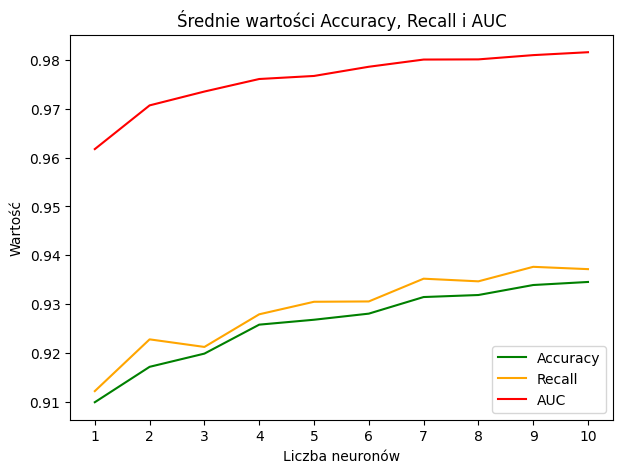

In [22]:
nn_models_neur = nn_models.groupby("neurons").agg({"accuracy": "mean", "recall": "mean", "auc": "mean"}).reset_index()
nn_models_neur
plt.figure(figsize=(7, 5))
sns.lineplot(data=nn_models_neur, x="neurons", y="accuracy", label="Accuracy", color="green")
sns.lineplot(data=nn_models_neur, x="neurons", y="recall", label="Recall", color="orange")
sns.lineplot(data=nn_models_neur, x="neurons", y="auc", label="AUC", color="red")
plt.xticks(nn_models_neur["neurons"])
plt.title("Średnie wartości Accuracy, Recall i AUC")
plt.xlabel("Liczba neuronów")
plt.ylabel("Wartość")
plt.show()


   drp  accuracy    recall       auc
0  0.0  0.928344  0.929907  0.977769
1  0.1  0.925187  0.929380  0.975511
2  0.2  0.924177  0.927575  0.974844


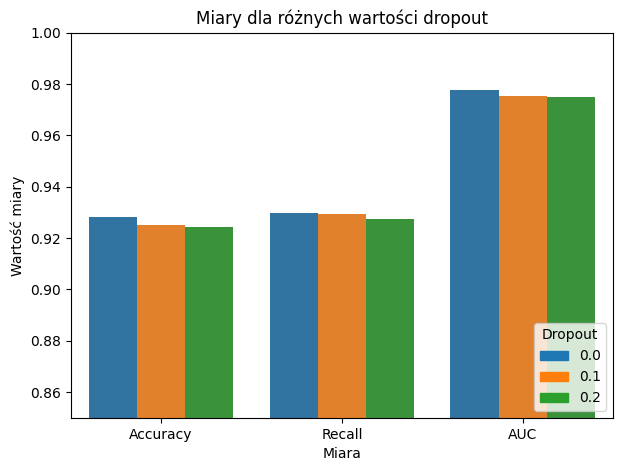

In [27]:
nn_models_drp = nn_models.groupby("drp").agg({"accuracy": "mean", "recall": "mean", "auc": "mean"}).reset_index()
print(nn_models_drp)
plt.figure(figsize=(7, 5))
df_melted = nn_models_drp.melt(id_vars='drp', var_name='metric', value_name='value')
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

sns.barplot(data=df_melted, x='metric', y='value', hue='drp', palette=colors)
plt.title('Miary dla różnych wartości dropout')
plt.xlabel('Miara')
plt.ylabel('Wartość miary')
plt.ylim(0.85, 1)
plt.xticks(range(3), ['Accuracy', 'Recall', 'AUC'])
legend_labels = ['0.0', '0.1', '0.2']  
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_handles, legend_labels, title='Dropout', loc='lower right')

plt.show()


       act  accuracy    recall       auc
0     relu  0.931250  0.934651  0.977800
1  sigmoid  0.917094  0.919303  0.972042
2     tanh  0.929365  0.932908  0.978283


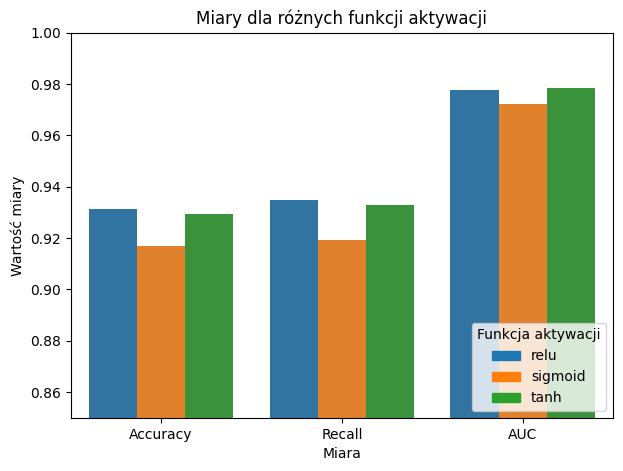

In [28]:
nn_models_act = nn_models.groupby("act").agg({"accuracy": "mean", "recall": "mean", "auc": "mean"}).reset_index()
print(nn_models_act)
plt.figure(figsize=(7, 5))
df_melted = nn_models_act.melt(id_vars='act', var_name='metric', value_name='value')
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

sns.barplot(data=df_melted, x='metric', y='value', hue='act', palette=colors)
plt.title('Miary dla różnych funkcji aktywacji')
plt.xlabel('Miara')
plt.ylabel('Wartość miary')
plt.ylim(0.85, 1)
plt.xticks(range(3), ['Accuracy', 'Recall', 'AUC'])
legend_labels = ['relu', 'sigmoid', 'tanh']  
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_handles, legend_labels, title='Funkcja aktywacji', loc='lower right')

plt.show()

       lr  accuracy    recall       auc
0  0.0001  0.914167  0.917329  0.969504
1  0.0010  0.937639  0.940579  0.982578


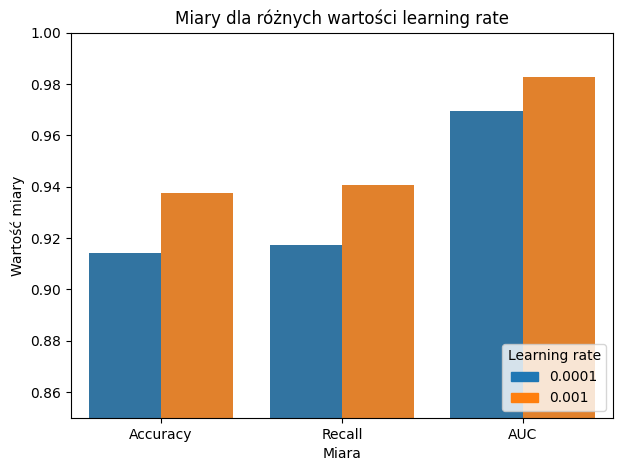

In [29]:
nn_models_lr = nn_models.groupby("lr").agg({"accuracy": "mean", "recall": "mean", "auc": "mean"}).reset_index()
print(nn_models_lr)
plt.figure(figsize=(7, 5))
df_melted = nn_models_lr.melt(id_vars='lr', var_name='metric', value_name='value')
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

sns.barplot(data=df_melted, x='metric', y='value', hue='lr', palette=colors)
plt.title('Miary dla różnych wartości learning rate')
plt.xlabel('Miara')
plt.ylabel('Wartość miary')
plt.ylim(0.85, 1)
plt.xticks(range(3), ['Accuracy', 'Recall', 'AUC'])
legend_labels = ['0.0001', '0.001'] 
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_handles, legend_labels, title='Learning rate', loc='lower right')

plt.show()

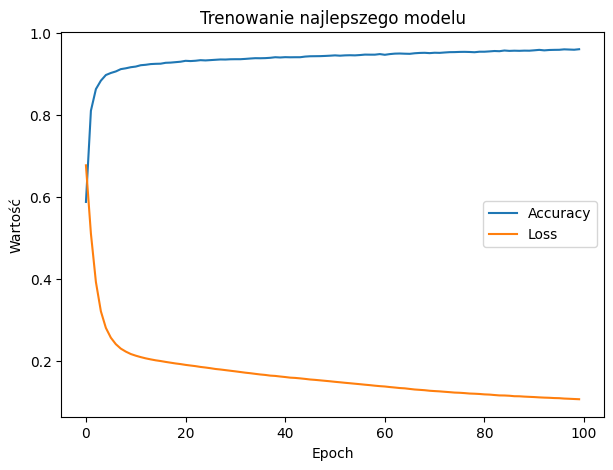

In [40]:
nn_models.sort_values(by="auc", ascending=False).head(1)["history"].values[0].history["accuracy"]
plt.figure(figsize=(7, 5))
plt.plot(nn_models.sort_values(by="auc", ascending=False).head(1)["history"].values[0].history["accuracy"], label="Accuracy")
plt.plot(nn_models.sort_values(by="auc", ascending=False).head(1)["history"].values[0].history["loss"], label="Loss")
plt.title("Trenowanie najlepszego modelu")
plt.xlabel("Epoch")
plt.ylabel("Wartość")
plt.legend()
plt.show()



50/50 [==============================] - 0s 280us/step


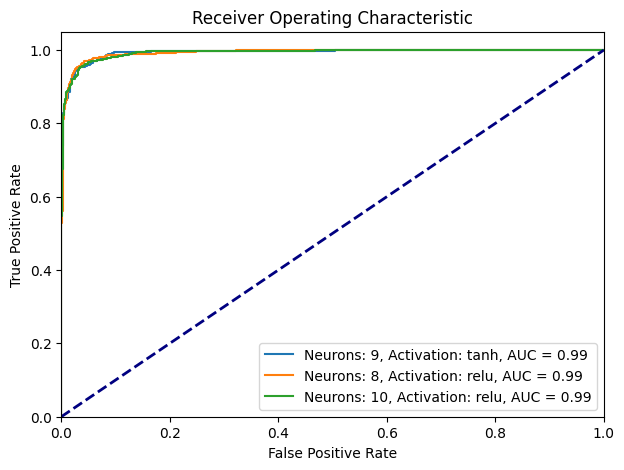

In [43]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models.sort_values(by="auc", ascending=False).head(1)["model"].values[0].predict(X_train_val))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Neurons: {nn_models.sort_values(by="auc", ascending=False).head(1)["neurons"].values[0]}, Activation: {nn_models.sort_values(by="auc", ascending=False).head(1)["act"].values[0]}, AUC = {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models.sort_values(by="auc", ascending=False).head(2)["model"].values[1].predict(X_train_val))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Neurons: {nn_models.sort_values(by="auc", ascending=False).head(2)["neurons"].values[1]}, Activation: {nn_models.sort_values(by="auc", ascending=False).head(2)["act"].values[1]}, AUC = {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models.sort_values(by="auc", ascending=False).head(3)["model"].values[2].predict(X_train_val))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Neurons: {nn_models.sort_values(by="auc", ascending=False).head(3)["neurons"].values[2]}, Activation: {nn_models.sort_values(by="auc", ascending=False).head(3)["act"].values[2]}, AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()




In [12]:
models_2 = pd.DataFrame(columns=["model", "history", "accuracy", "recall", "auc"])
for neurons1 in range(4, 7):
    for act1 in ["sigmoid", "tanh", "relu"]:
        for drp1 in [0, 0.1, 0.2]:
            for neurons2 in range(3, 6):
                for act2 in ["sigmoid", "tanh", "relu"]:


                    temp_nn = Sequential([
                        Dense(neurons1, activation=act1, input_shape=(19,)),
                        Dropout(drp1),
                        Dense(neurons2, activation=act2), 
                        Dropout(drp1),
                        Dense(1, activation='sigmoid') 
                    ])

                    temp_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
                    temp_nn.compile(optimizer=temp_opt, loss='binary_crossentropy', metrics=['accuracy'])

                    temp_history = temp_nn.fit(X_train_train, y_train_train, batch_size=64, epochs=100)
                    temp_preds = temp_nn.predict(X_train_val)
                    temp_preds = pd.DataFrame(temp_preds)
                    temp_preds.columns = ["prob"]
                    fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], temp_preds['prob'])
                    roc_auc = auc(fpr, tpr)
                    temp_preds["class"] = temp_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)
                    models_2 = pd.concat([models_2, pd.DataFrame([[temp_nn, temp_history, accuracy_score(y_train_val, temp_preds["class"]), recall_score(y_train_val, temp_preds["class"]), roc_auc]], columns=["model", "history", "accuracy", "recall", "auc"])])


Epoch 1/100
100/100 [==============================] - 0s 497us/step - loss: 0.6714 - accuracy: 0.5553
Epoch 2/100
100/100 [==============================] - 0s 395us/step - loss: 0.6434 - accuracy: 0.7758
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6062 - accuracy: 0.8236
Epoch 4/100
100/100 [==============================] - 0s 517us/step - loss: 0.5583 - accuracy: 0.8522
Epoch 5/100
100/100 [==============================] - 0s 395us/step - loss: 0.5070 - accuracy: 0.8723
Epoch 6/100
100/100 [==============================] - 0s 385us/step - loss: 0.4592 - accuracy: 0.8798
Epoch 7/100
100/100 [==============================] - 0s 389us/step - loss: 0.4182 - accuracy: 0.8881
Epoch 8/100
100/100 [==============================] - 0s 419us/step - loss: 0.3842 - accuracy: 0.8916
Epoch 9/100
100/100 [==============================] - 0s 387us/step - loss: 0.3568 - accuracy: 0.8947
Epoch 10/100
100/100 [==============================] - 0s 420us/step - los

100/100 [==============================] - 0s 779us/step - loss: 0.1966 - accuracy: 0.9228
Epoch 37/100
100/100 [==============================] - 0s 537us/step - loss: 0.1961 - accuracy: 0.9241
Epoch 38/100
100/100 [==============================] - 0s 423us/step - loss: 0.1957 - accuracy: 0.9236
Epoch 39/100
100/100 [==============================] - 0s 941us/step - loss: 0.1950 - accuracy: 0.9234
Epoch 40/100
100/100 [==============================] - 0s 416us/step - loss: 0.1951 - accuracy: 0.9239
Epoch 41/100
100/100 [==============================] - 0s 601us/step - loss: 0.1945 - accuracy: 0.9237
Epoch 42/100
100/100 [==============================] - 0s 540us/step - loss: 0.1942 - accuracy: 0.9253
Epoch 43/100
100/100 [==============================] - 0s 961us/step - loss: 0.1942 - accuracy: 0.9250
Epoch 44/100
100/100 [==============================] - 0s 412us/step - loss: 0.1937 - accuracy: 0.9250
Epoch 45/100
100/100 [==============================] - 0s 407us/step - loss:

In [13]:
models_2.to_csv("models_2.csv", sep=";", index=False)

In [16]:
models_2

model  \
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
..                                                ...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   

                                              history  accuracy    recall  \
0   <keras.src.callbacks.History object at 0x30804...  0.936250  0.939173   
0   <keras.src.callbacks.History object at 0x30a40...  0.938750  0.937956   
0   <keras.src.callbacks.History object at 0x30a40...  0.936250  0.936740   
0   <keras.src.callbacks.History object at 0x30ba8...  0.936250  0.944039   
0   <keras.src.callbacks.History object at 0x30c1e...  0.939375  0.934307   
..                                                ...       ...       ...   
0   <keras.src.callbacks.History object at 0x38c81...  0.936875  0.948905   
0   <keras.src.callbacks.History object at 0x38bf0...  0.945625  0.936740   
0   <keras.src.callbacks.History object at 0x38db0...  0.948750  0.956204   
0   <keras.src.callbacks.History object at 0x38eb5...  0.936875  0.951338   
0   <keras.src.callbacks.History object at 0x38eb4...  0.937500  0.944039   

         auc  
0   0.982396  
0   0.982554  
0   0.982626  
0   0.982785  
0   0.985455  
..       ...  
0   0.983141  
0   0.984044  
0   0.986476  
0   0.984473  
0   0.983208  

[243 rows x 5 columns]

In [17]:
nn_models_2 = models_2.copy()
nn_models_2["lr"] = nn_models_2["model"].apply(lambda x: x.optimizer.get_config()["learning_rate"])
nn_models_2["act1"] = nn_models_2["model"].apply(lambda x: x.layers[0].activation)
nn_models_2["act2"] = nn_models_2["model"].apply(lambda x: x.layers[2].activation)
nn_models_2["drp"] = nn_models_2["model"].apply(lambda x: x.layers[1].rate)
nn_models_2["neurons1"] = nn_models_2["model"].apply(lambda x: x.layers[0].units)
nn_models_2["neurons2"] = nn_models_2["model"].apply(lambda x: x.layers[2].units)
nn_models_2["epochs"] = nn_models_2["history"].apply(lambda x: len(x.history["loss"]))
nn_models_2 = nn_models_2.sort_values(by="auc", ascending=False)
nn_models_2["act1"] = nn_models_2["act1"].apply(lambda x: x.__name__)
nn_models_2["act2"] = nn_models_2["act2"].apply(lambda x: x.__name__)
nn_models_2

model  \
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
..                                                ...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   
0   <keras.src.engine.sequential.Sequential object...   

                                              history  accuracy    recall  \
0   <keras.src.callbacks.History object at 0x3806a...  0.961250  0.958637   
0   <keras.src.callbacks.History object at 0x381a7...  0.961250  0.957421   
0   <keras.src.callbacks.History object at 0x374ff...  0.959375  0.953771   
0   <keras.src.callbacks.History object at 0x34ce6...  0.956875  0.956204   
0   <keras.src.callbacks.History object at 0x381a7...  0.950625  0.953771   
..                                                ...       ...       ...   
0   <keras.src.callbacks.History object at 0x312b2...  0.929375  0.945255   
0   <keras.src.callbacks.History object at 0x31517...  0.927500  0.927007   
0   <keras.src.callbacks.History object at 0x3131b...  0.928125  0.940389   
0   <keras.src.callbacks.History object at 0x330f1...  0.925625  0.896594   
0   <keras.src.callbacks.History object at 0x3131b...  0.926250  0.911192   

         auc     lr     act1     act2  drp  neurons1  neurons2  epochs  
0   0.991811  0.001     relu     tanh  0.0         6         4     100  
0   0.991359  0.001     relu     relu  0.0         6         5     100  
0   0.991129  0.001     tanh     relu  0.0         6         3     100  
0   0.991046  0.001     tanh     tanh  0.0         6         5     100  
0   0.990741  0.001     relu  sigmoid  0.0         6         4     100  
..       ...    ...      ...      ...  ...       ...       ...     ...  
0   0.976210  0.001  sigmoid  sigmoid  0.2         4         3     100  
0   0.976076  0.001  sigmoid  sigmoid  0.2         4         5     100  
0   0.975910  0.001  sigmoid     tanh  0.2         4         3     100  
0   0.975073  0.001     relu     relu  0.2         4         4     100  
0   0.969088  0.001  sigmoid     relu  0.2         4         3     100  

[243 rows x 12 columns]

In [18]:
nn_models_2.sort_values(by="auc", ascending=False).head(10)

model  \
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   
0  <keras.src.engine.sequential.Sequential object...   

                                             history  accuracy    recall  \
0  <keras.src.callbacks.History object at 0x3806a...  0.961250  0.958637   
0  <keras.src.callbacks.History object at 0x381a7...  0.961250  0.957421   
0  <keras.src.callbacks.History object at 0x374ff...  0.959375  0.953771   
0  <keras.src.callbacks.History object at 0x34ce6...  0.956875  0.956204   
0  <keras.src.callbacks.History object at 0x381a7...  0.950625  0.953771   
0  <keras.src.callbacks.History object at 0x3536b...  0.957500  0.956204   
0  <keras.src.callbacks.History object at 0x38801...  0.956250  0.961071   
0  <keras.src.callbacks.History object at 0x3831a...  0.960625  0.956204   
0  <keras.src.callbacks.History object at 0x356ed...  0.956875  0.951338   
0  <keras.src.callbacks.History object at 0x342a8...  0.964375  0.967153   

        auc     lr  act1     act2  drp  neurons1  neurons2  epochs  
0  0.991811  0.001  relu     tanh  0.0         6         4     100  
0  0.991359  0.001  relu     relu  0.0         6         5     100  
0  0.991129  0.001  tanh     relu  0.0         6         3     100  
0  0.991046  0.001  tanh     tanh  0.0         6         5     100  
0  0.990741  0.001  relu  sigmoid  0.0         6         4     100  
0  0.990640  0.001  relu     relu  0.0         5         5     100  
0  0.990599  0.001  relu     relu  0.1         6         4     100  
0  0.990507  0.001  relu     tanh  0.0         6         5     100  
0  0.990288  0.001  relu     tanh  0.1         5         5     100  
0  0.990258  0.001  tanh     relu  0.0         5         3     100

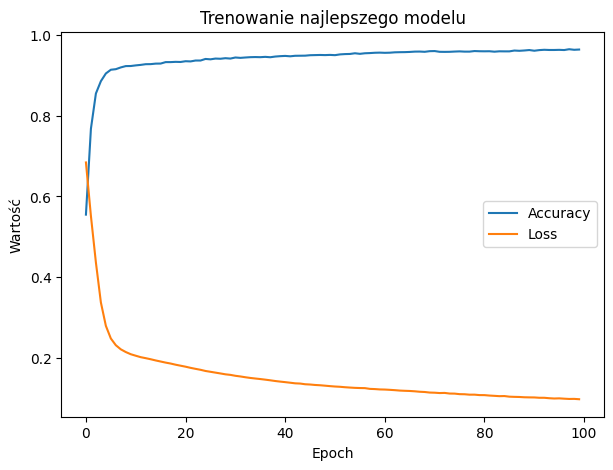

In [44]:
plt.figure(figsize=(7, 5))
plt.plot(nn_models_2.sort_values(by="auc", ascending=False).head(1)["history"].values[0].history["accuracy"], label="Accuracy")
plt.plot(nn_models_2.sort_values(by="auc", ascending=False).head(1)["history"].values[0].history["loss"], label="Loss")
plt.title("Trenowanie najlepszego modelu")
plt.xlabel("Epoch")
plt.ylabel("Wartość")
plt.legend()
plt.show()

50/50 [==============================] - 0s 354us/step


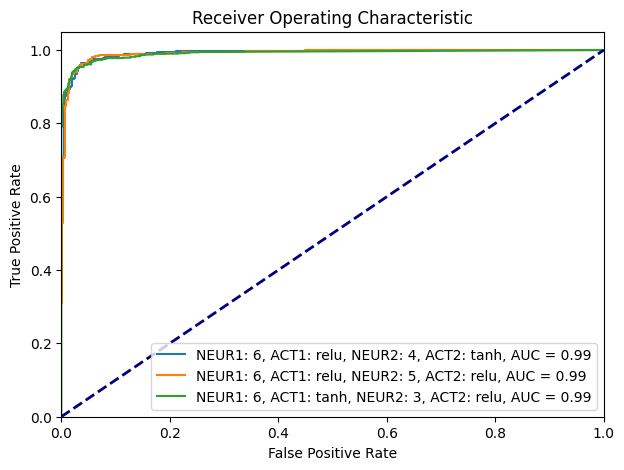

In [48]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models_2.sort_values(by="auc", ascending=False).head(1)["model"].values[0].predict(X_train_val))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'NEUR1: {nn_models_2.sort_values(by="auc", ascending=False).head(1)["neurons1"].values[0]}, ACT1: {nn_models_2.sort_values(by="auc", ascending=False).head(1)["act1"].values[0]}, NEUR2: {nn_models_2.sort_values(by="auc", ascending=False).head(1)["neurons2"].values[0]}, ACT2: {nn_models_2.sort_values(by="auc", ascending=False).head(1)["act2"].values[0]}, AUC = {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models_2.sort_values(by="auc", ascending=False).head(2)["model"].values[1].predict(X_train_val))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'NEUR1: {nn_models_2.sort_values(by="auc", ascending=False).head(2)["neurons1"].values[1]}, ACT1: {nn_models_2.sort_values(by="auc", ascending=False).head(2)["act1"].values[1]}, NEUR2: {nn_models_2.sort_values(by="auc", ascending=False).head(2)["neurons2"].values[1]}, ACT2: {nn_models_2.sort_values(by="auc", ascending=False).head(2)["act2"].values[1]}, AUC = {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(y_train_val['CLASS_LABEL'], nn_models_2.sort_values(by="auc", ascending=False).head(3)["model"].values[2].predict(X_train_val))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'NEUR1: {nn_models_2.sort_values(by="auc", ascending=False).head(3)["neurons1"].values[2]}, ACT1: {nn_models_2.sort_values(by="auc", ascending=False).head(3)["act1"].values[2]}, NEUR2: {nn_models_2.sort_values(by="auc", ascending=False).head(3)["neurons2"].values[2]}, ACT2: {nn_models_2.sort_values(by="auc", ascending=False).head(3)["act2"].values[2]}, AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(
    loc='lower right')

plt.show()

In [28]:
evaluate(y_test["CLASS_LABEL"], nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))

 Accuracy: 0.9004502251125562 
 Recall: 0.939 
 Specificity: 0.8618618618618619 
 Precision: 0.871866295264624 
 F1: 0.9041887337506018


In [209]:
print("Tree")
print(confusion_matrix(test["CLASS_LABEL"], tree_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], tree_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], tree_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], tree_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
tn, fp, fn, tp = confusion_matrix(test["CLASS_LABEL"], tree_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)).ravel()
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')


Tree
[[931  69]
 [ 87 913]]
Accuracy: 0.922
Recall: 0.913
Precision: 0.929735234215886
Specificity: 0.931


In [210]:
print("RF")
print(confusion_matrix(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
tn, fp, fn, tp = confusion_matrix(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)).ravel()
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')


RF
[[977  23]
 [ 15 985]]
Accuracy: 0.981
Recall: 0.985
Precision: 0.9771825396825397
Specificity: 0.977


In [211]:
print("Log")
print(confusion_matrix(test["CLASS_LABEL"], log_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], log_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], log_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], log_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
tn, fp, fn, tp = confusion_matrix(test["CLASS_LABEL"], log_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)).ravel()
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')


Log
[[914  86]
 [ 73 927]]
Accuracy: 0.9205
Recall: 0.927
Precision: 0.9151036525172754
Specificity: 0.914


In [212]:
#evaluate(test["CLASS_LABEL"], pd.DataFrame(nn_models.sort_values(by="auc", ascending=False).head(1)["model"].values[0].predict(X_test)).apply(lambda x: 1 if x > 0.5 else 0))
best_nn1_preds = nn_models.sort_values(by="auc", ascending=False).head(1)["model"].values[0].predict(X_test)
best_nn1_preds = pd.DataFrame(best_nn1_preds)
best_nn1_preds.columns = ["prob"]
print("NN1")
print(confusion_matrix(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
tn, fp, fn, tp = confusion_matrix(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)).ravel()
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')

63/63 [==============================] - 0s 379us/step
NN1
[[948  52]
 [ 44 956]]
Accuracy: 0.952
Recall: 0.956
Precision: 0.9484126984126984
Specificity: 0.948


In [213]:
best_nn2_preds = nn_models_2.sort_values(by="auc", ascending=False).head(1)["model"].values[0].predict(X_test)
best_nn2_preds = pd.DataFrame(best_nn2_preds)
best_nn2_preds.columns = ["prob"]
print("NN2")
print(confusion_matrix(test["CLASS_LABEL"], best_nn2_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], best_nn2_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], best_nn2_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], best_nn2_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))}')
tn, fp, fn, tp = confusion_matrix(test["CLASS_LABEL"], best_nn2_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0)).ravel()
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')


63/63 [==============================] - 0s 401us/step
NN2
[[956  44]
 [ 54 946]]
Accuracy: 0.951
Recall: 0.946
Precision: 0.9555555555555556
Specificity: 0.956


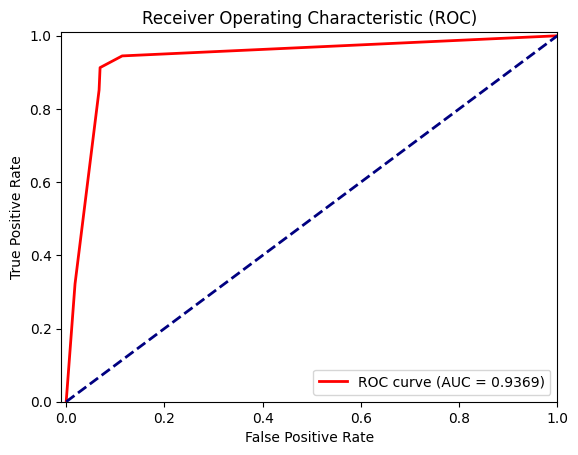

In [214]:
fpr_tree, tpr_tree, thresholds_tree = roc_curve(test['CLASS_LABEL'], tree_preds['prob'])
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure()
plt.plot(fpr_tree, tpr_tree, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_tree)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

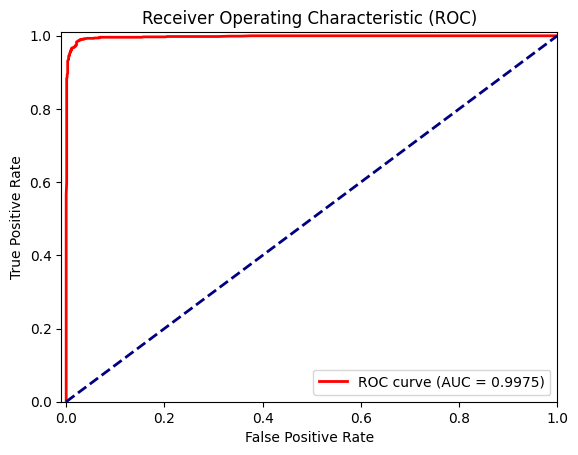

In [215]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test['CLASS_LABEL'], rf_preds['prob'])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

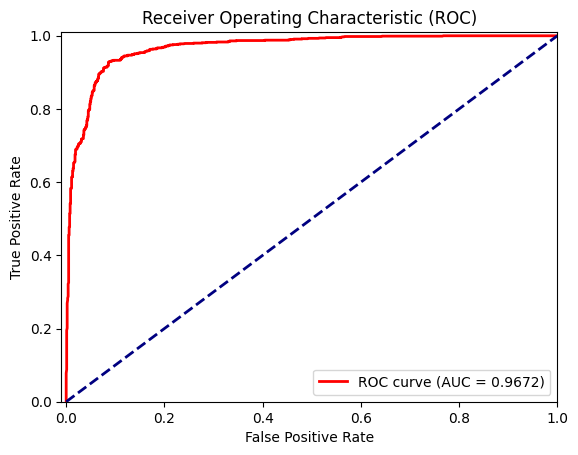

In [216]:
fpr_log, tpr_log, thresholds_log = roc_curve(test['CLASS_LABEL'], log_preds['prob'])
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure()
plt.plot(fpr_log, tpr_log, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_log)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

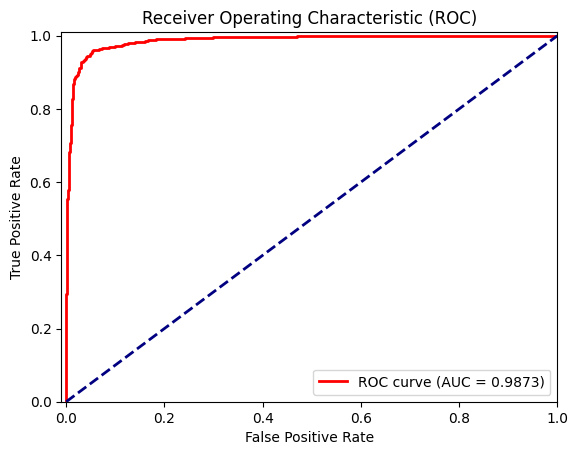

In [68]:
fpr_nn1, tpr_nn1, thresholds_nn1 = roc_curve(test['CLASS_LABEL'], best_nn1_preds['prob'])
roc_auc_nn1 = auc(fpr_nn1, tpr_nn1)

plt.figure()
plt.plot(fpr_nn1, tpr_nn1, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_nn1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

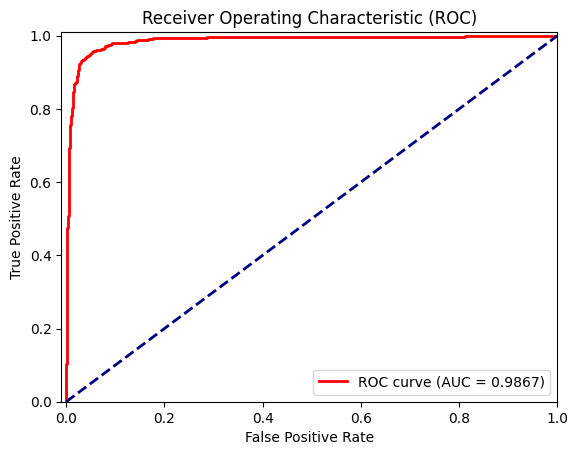

In [217]:
fpr_nn2, tpr_nn2, thresholds_nn2 = roc_curve(test['CLASS_LABEL'], best_nn2_preds['prob'])
roc_auc_nn2 = auc(fpr_nn2, tpr_nn2)

plt.figure()
plt.plot(fpr_nn2, tpr_nn2, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_nn2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

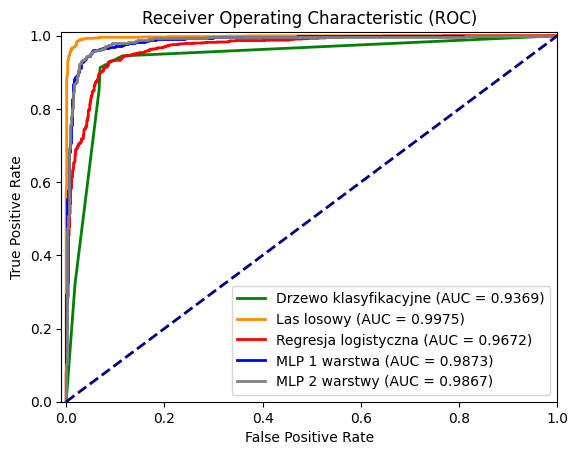

In [77]:
plt.figure()
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label='Drzewo klasyfikacyjne (AUC = %0.4f)' % roc_auc_tree)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Las losowy (AUC = %0.4f)' % roc_auc_rf)
plt.plot(fpr_log, tpr_log, color='red', lw=2, label='Regresja logistyczna (AUC = %0.4f)' % roc_auc_log)
plt.plot(fpr_nn1, tpr_nn1, color='blue', lw=2, label='MLP 1 warstwa (AUC = %0.4f)' % roc_auc_nn1)
plt.plot(fpr_nn2, tpr_nn2, color='gray', lw=2, label='MLP 2 warstwy (AUC = %0.4f)' % roc_auc_nn2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lift_curve(y_val_list, y_pred_list, step=0.01):
    colors = ['green', 'darkorange', 'red', 'blue', 'gray'] 
    legends = [] 

    
    for i, (y_val, y_pred) in enumerate(zip(y_val_list, y_pred_list)):
        aux_lift = pd.DataFrame()
        aux_lift['real'] = y_val
        aux_lift['predicted'] = y_pred
        aux_lift.sort_values('predicted', ascending=False, inplace=True)

    
        x_val = np.arange(step, 1 + step, step)
        ratio_ones = aux_lift['real'].sum() / len(aux_lift)

        y_v = []

        for x in x_val:
            num_data = int(np.ceil(x * len(aux_lift)))  
            data_here = aux_lift.iloc[:num_data, :]  
            ratio_ones_here = data_here['real'].sum() / len(data_here)
            y_v.append(ratio_ones_here / ratio_ones)


        plt.plot(x_val, y_v, linewidth=3, markersize=5, color=colors[i])
        legends.append(f'Curve {i+1}')

    plt.xlabel('Odsetek obserwacji')
    plt.ylabel('Wartość lift')
    plt.title('Combined Lift Curves')

    legends.append('Baseline (Random)')
    plt.legend(legends, loc='lower left')


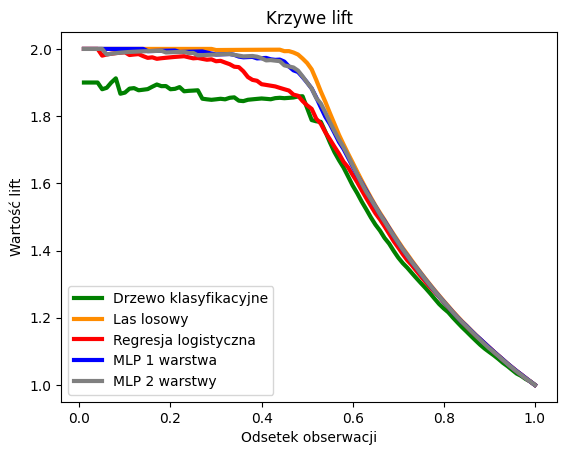

In [109]:
plot_lift_curve([y_test]*5, [tree_preds["prob"], rf_preds["prob"], log_preds["prob"], best_nn1_preds["prob"], best_nn2_preds["prob"]])
plt.legend(["Drzewo klasyfikacyjne", "Las losowy", "Regresja logistyczna", "MLP 1 warstwa", "MLP 2 warstwy", "Baseline (Random)"], loc='lower left')


plt.title("Krzywe lift")

plt.show()



In [96]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    x_val = np.arange(step,1+step,step)

    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    y_v = []
    

    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) 
        data_here = aux_lift.iloc[:num_data,:]   
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [220]:
def plot_roc_curve(y_val, y_pred, step=0.01):
    x_val = np.arange(0,1+step,step)
    tpr_v = []
    fpr_v = []

    for threshold in x_val:
        y_pred_class = y_pred.apply(lambda x: 1 if x > threshold else 0)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_class).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_v.append(tpr)
        fpr_v.append(fpr)
        print(tpr)
    
    return pd.DataFrame({'tpr': tpr_v, 'fpr': fpr_v}, index=x_val)

tabela = plot_roc_curve(test["CLASS_LABEL"], rf_preds["prob"])

1.0
1.0
1.0
1.0
0.999
0.998
0.998
0.998
0.998
0.997
0.997
0.997
0.997
0.997
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.996
0.995
0.994
0.994
0.994
0.994
0.993
0.993
0.993
0.993
0.992
0.992
0.991
0.991
0.991
0.99
0.99
0.99
0.988
0.988
0.987
0.987
0.985
0.984
0.983
0.981
0.979
0.975
0.973
0.973
0.972
0.97
0.969
0.967
0.967
0.965
0.962
0.962
0.959
0.959
0.959
0.957
0.955
0.954
0.951
0.95
0.948
0.946
0.943
0.942
0.938
0.935
0.931
0.927
0.917
0.915
0.906
0.901
0.891
0.887
0.877
0.869
0.854
0.846
0.829
0.81
0.795
0.77
0.724
0.699
0.637
0.567
0.0


In [223]:
tabela[(tabela["tpr"] > 0.97) & (tabela["fpr"] < 0.07)]

tpr    fpr
0.28  0.996  0.069
0.29  0.995  0.068
0.30  0.994  0.067
0.31  0.994  0.062
0.32  0.994  0.060
0.33  0.994  0.058
0.34  0.993  0.054
0.35  0.993  0.050
0.36  0.993  0.046
0.37  0.993  0.042
0.38  0.992  0.039
0.39  0.992  0.037
0.40  0.991  0.035
0.41  0.991  0.035
0.42  0.991  0.033
0.43  0.990  0.033
0.44  0.990  0.029
0.45  0.990  0.029
0.46  0.988  0.029
0.47  0.988  0.026
0.48  0.987  0.026
0.49  0.987  0.026
0.50  0.985  0.023
0.51  0.984  0.022
0.52  0.983  0.021
0.53  0.981  0.021
0.54  0.979  0.021
0.55  0.975  0.021
0.56  0.973  0.020
0.57  0.973  0.020
0.58  0.972  0.019

In [230]:
print("RF nowy prog")
print(confusion_matrix(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.45 else 0)))
print(f'Accuracy: {accuracy_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.45 else 0))}')
print(f'Recall: {recall_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.45 else 0))}')
print(f'Precision: {precision_score(test["CLASS_LABEL"], rf_preds["prob"].apply(lambda x: 1 if x > 0.45 else 0))}')
print(f'Specificity: {1-tabela.loc[0.45]["fpr"]}')

RF nowy prog
[[971  29]
 [ 10 990]]
Accuracy: 0.9805
Recall: 0.99
Precision: 0.971540726202159
Specificity: 0.971


In [222]:
accuracy_score(test["CLASS_LABEL"], best_nn1_preds["prob"].apply(lambda x: 1 if x > 0.5 else 0))

0.952